## Amazon Fine Foods Review classification

### Problem Statement

You are an Amazon data scientist and have been asked to find out insights from the 'Amazon Fine Foods Review' data. Your aim is to do text classification using Deep Learning on the reviews. This dataset has various features but for this project you will only need the `reviews(text)` as training data. This is a supervised Learning task so you will use `Score` as the label, while training. You have to make a classification model which will rate the review at a scale from 1 to 5.

### About the dataset

This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories. The original data contains `568,454` reviews collected from `256,059` users on `74,258` products. 

The snapshot of the data, you will be working on :

![](data.PNG)



They have been divided into a zip file.

A zipped file containing the following items is given:

- `train.csv`

The data file `train.csv` contains the `40500` instances with the `3` features including the target feature

- `test.csv`

The datafile `test.csv` contains the `1000`instances with the `2` feature excluding the target feature.

- `sample_submission.csv` 

Explained under the `Submission` sub-heading


- `food_review_classification_student_template.ipynb`

A template notebook explaining the task breakdown to solve the given problem statement
(***Learners are recommended to use it***)

## Submission

After training the model on `train.csv` data, the learner has to predict the target feature of the `test.csv` data using the trained model. The learner has to then submit a csv file with the predicted feature.

Sample submission file(`sample_submission.csv`) is given to you as a reference to the format expected when you submit 


## Evaluation metrics

For this particular dataset we are using simple `F1 Score`(weighted) as the evaluation metric. 

Submissions will be evaluated based on [F1 score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) as  per the below threshold.


|Your `F1 score` score| Points earned for the Task|
|-----|-----|
|`F1 score`>= 0.63|100% of the available points|
| 0.63 > `F1 score` >= 0.60 |80% of the available points|
| 0.60 > `F1 score` >= 0.55 |70% of the available points|
|`F1 score` < 0.55|No points earned|


### Outcomes

After completing this project you will understand the basic pipeline of sentiment classification using Deep Learning. In this project you will apply the following concepts:

- Word Embeddings using GloVe
- LSTM using keras



### Acknowledgements

More information about the datasets can be found at https://www.kaggle.com/snap/amazon-fine-food-reviews.




### Load Data

In [3]:
# Import the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import re

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# nltk
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize,sent_tokenize

# keras
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfTransformer
import seaborn as sb
import matplotlib.pyplot as plt
import gensim

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
link = 'https://drive.google.com/open?id=1JlRjke8cf_ueJHpxFTQzX4wj39Fux0ws' # The shareable link
fluff, id = link.split('=')
print(id) # Verify that you have everything after '='

1JlRjke8cf_ueJHpxFTQzX4wj39Fux0ws


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.csv')  
train = pd.read_csv('train.csv')

In [8]:
# Load Data
df = pd.read_csv("train.csv")
# df = df[:7000]

# Function to pre-process one sample
def pre_process(review=None):
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    return review
    

# Pre-process the entire column of reviews of train and test
corpus = []
for i in range(df.shape[0]):
    review = pre_process(df['Text'][i])
    corpus.append(review)
    
# Make a new dataframe using the reviews and score
corpus = pd.DataFrame(corpus, columns=['Text']) 
result = corpus.join([df['Score']])
result.dropna(inplace=True)
result['Score'] = result['Score'].astype('int')

result.head()

,Text,Score
0,bought larg chain pet store read review check ...,1
1,soup incred good honestli look better deal ama...,5
2,famili love tasti healthi sesam honey almond t...,5
3,local auto shop offer free custom tri twice li...,4
4,brought bottl one carri pocket home fell love ...,5















### Visualization using t-SNE and Word2Vec

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


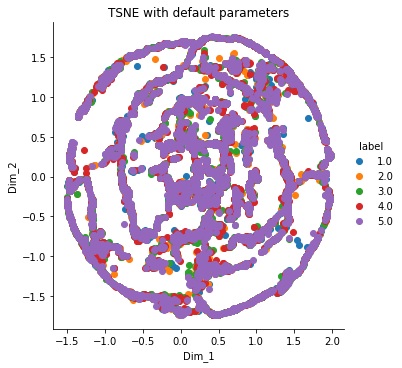

In [9]:
# Implement TF-IDF
tfidf_vect = TfidfVectorizer(ngram_range=(1,1))
tfidf_data = result['Text']
tfidf_data = tfidf_vect.fit_transform(tfidf_data)
tfidf_data = tfidf_data.todense()


# Implement Word2Vec
w2v_points = result['Text']
sent_list = []
for sent in w2v_points:
    sentence = sent.split()
    sent_list.append(sentence)
w2v_model = gensim.models.Word2Vec(sent_list, min_count=5, size=50, workers=4)
w2v_words = w2v_model[w2v_model.wv.vocab]


# Construct sentence vectors from aove 2 results
tfidf_feat = tfidf_vect.get_feature_names()
tfidf_w2v_vectors = []
row = 0
for sent in sent_list:
    sent_vec = np.zeros(200)
    weight_sum = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec*tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_w2v_vectors.append(sent_vec)
    row += 1


# Implement t-SNE
labels = result['Score']
model = TSNE(n_components=2, random_state=15, perplexity=30, n_iter=2000)
tfidf_w2v_points = model.fit_transform(tfidf_w2v_vectors)
tsne_data = np.vstack((tfidf_w2v_points.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1', 'Dim_2', 'label'))


# Plotting graph for class labels
sb.FacetGrid(tsne_df, hue='label', size=5).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE with default parameters")
plt.xlabel("Dim_1")
plt.ylabel("Dim_2")
plt.show()

### Model Building

In [10]:
# Tokenize words to be fed to the model
max_fatures = 10000
tokenizer = Tokenizer(nb_words=max_fatures, split=' ')
tokenizer.fit_on_texts(result['Text'].values)
# tokenizer.fit_on_texts(X_test)
# tokenizer.fit_on_texts(X-test['Text'].values)
X_train = tokenizer.texts_to_sequences(result['Text'].values)
X_train = pad_sequences(X_train)
Y_train = pd.get_dummies(result['Score']).values


# Create the sequential model

embed_dim = 150
lstm_out = 200

model = Sequential()

model.add(Embedding(max_fatures, embed_dim,input_length = X_train.shape[1]))
model.add(LSTM(lstm_out))
model.add(Dense(5,activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 955, 150)          1500000   
_________________________________________________________________
lstm (LSTM)                  (None, 200)               280800    
_________________________________________________________________
dense (Dense)                (None, 5)                 1005      
Total params: 1,781,805
Trainable params: 1,781,805
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
# Train
batch_size = 32
model.fit(X_train, Y_train, epochs = 10, batch_size=batch_size, verbose = 2)

Epoch 1/10
1266/1266 - 94s - loss: 1.2532 - accuracy: 0.4586
Epoch 2/10
1266/1266 - 94s - loss: 1.0475 - accuracy: 0.5659
Epoch 3/10
1266/1266 - 94s - loss: 0.9123 - accuracy: 0.6336
Epoch 4/10
1266/1266 - 95s - loss: 0.7819 - accuracy: 0.6963
Epoch 5/10
1266/1266 - 95s - loss: 0.6620 - accuracy: 0.7484
Epoch 6/10
1266/1266 - 96s - loss: 0.5456 - accuracy: 0.7954
Epoch 7/10
1266/1266 - 98s - loss: 0.4430 - accuracy: 0.8391
Epoch 8/10
1266/1266 - 98s - loss: 0.3459 - accuracy: 0.8773
Epoch 9/10
1266/1266 - 98s - loss: 0.2643 - accuracy: 0.9073
Epoch 10/10
1266/1266 - 98s - loss: 0.2091 - accuracy: 0.9296


## Validation of test data

Let's now see how well our models run on test set.


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [14]:
link = 'https://drive.google.com/open?id=1sjeQvSI7CfVn3rTIH-pqAU8CidWUv4xx' # The shareable link
fluff, id = link.split('=')
print(id) # Verify that you have everything after '='

1sjeQvSI7CfVn3rTIH-pqAU8CidWUv4xx


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('test.csv')  
test_df = pd.read_csv('test.csv')

In [16]:
test_df = pd.read_csv("test.csv")

# Y_test = pd.read_csv("actual.csv")




X_test = []
for i in range(test_df.shape[0]):
    review = pre_process(test_df['Text'][i])
    X_test.append(review)

X_test1 = tokenizer.texts_to_sequences(X_test)
X_test1 = pad_sequences(X_test1, maxlen=X_train.shape[1])

y_pred=model.predict(X_test1)

y_pred2=np.argmax(y_pred, axis=1)
y_pred2= [x+1 for x in y_pred2]



submission_3=pd.DataFrame(y_pred2)
from google.colab import drive
drive.mount('drive', force_remount=True)

# After authentication, you can copy your csv file.

submission_3.to_csv('submission_reviews_3.csv',index=False,header=['Score'])
!cp submission_reviews_3.csv "drive/My Drive/"  

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive
